In [1]:
store -r wba127_clean_status

In [2]:
import warnings
import pandas as pd
from datetime import datetime, timedelta,date
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import lightgbm

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor, XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, \
                                    Input, Embedding, Masking, Bidirectional, Conv1D, Flatten, \
                                    MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
wba127_alarm = pd.read_excel("../Data/WBA127_FullAlarm.xlsx", usecols = "B,C,D,F,M")

In [4]:
wba127_clean_status

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
0,WBA127,2018-12-13 08:14:22,2018-12-13 08:17:03,161.0,SHORT TAIL,Unscheduled Down (UD),UDT
1,WBA127,2018-12-13 08:17:03,2018-12-13 08:17:58,55.0,Normal Production,Productive (PR),PRD
2,WBA127,2018-12-13 08:17:58,2018-12-13 08:21:29,211.0,Waiting For Response,Standby (SB),SBY
3,WBA127,2018-12-13 08:21:29,2018-12-13 08:54:09,1960.0,Normal Production,Productive (PR),PRD
4,WBA127,2018-12-13 08:54:09,2018-12-13 08:58:01,232.0,Waiting For Response,Standby (SB),SBY
...,...,...,...,...,...,...,...
132913,WBA127,2021-10-28 05:10:00,2021-10-28 05:30:02,1202.0,Normal Production,Productive (PR),PRD
132914,WBA127,2021-10-28 05:30:02,2021-10-28 05:49:09,1147.0,Change Wire,Scheduled Down (SD),SDT
132915,WBA127,2021-10-28 05:49:09,2021-10-28 05:50:03,54.0,SHORT TAIL,Unscheduled Down (UD),UDT
132916,WBA127,2021-10-28 05:50:03,2021-10-28 06:42:36,3153.0,Normal Production,Productive (PR),PRD


In [5]:
def combine_same_status(data):
    data['LEVEL3_LAST'] = data['LEVEL3'].shift(1)
    data['COMPARE'] = [data['LEVEL3_LAST'][r] == data['LEVEL3'][r] for r in range(len(data))]
    data['CASE'] = 1
    
    for i in range(1, len(data)):
        if data['COMPARE'][i] == True:
            data['CASE'][i] = data['CASE'][i-1]
        else:
            data['CASE'][i] = data['CASE'][i-1]+1
    
    output = data.groupby(['EQ_ID', 'CASE', 'LEVEL3']).agg({'TIMESTAMP_START': 'min', 'TIMESTAMP_END': 'max', 'DURATION': 'sum'})
    output = output.reset_index()
    return output

In [6]:
# 1. Combine all timestamp and duration for all with the same UDT as LEVEL3
wba127_combined_status = combine_same_status(wba127_clean_status)

In [7]:
# 2. Map state name over to the new combined table
wba127_combined_status['STATE_NAME'] = wba127_combined_status['TIMESTAMP_START'].\
                                        map(wba127_clean_status.set_index('TIMESTAMP_START')['STATE_NAME'])

In [8]:
wba127_combined_status

,EQ_ID,CASE,LEVEL3,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME
0,WBA127,1,UDT,2018-12-13 08:14:22,2018-12-13 08:17:03,161.0,SHORT TAIL
1,WBA127,2,PRD,2018-12-13 08:17:03,2018-12-13 08:17:58,55.0,Normal Production
2,WBA127,3,SBY,2018-12-13 08:17:58,2018-12-13 08:21:29,211.0,Waiting For Response
3,WBA127,4,PRD,2018-12-13 08:21:29,2018-12-13 08:54:09,1960.0,Normal Production
4,WBA127,5,SBY,2018-12-13 08:54:09,2018-12-13 08:58:01,232.0,Waiting For Response
...,...,...,...,...,...,...,...
126280,WBA127,126281,PRD,2021-10-28 05:10:00,2021-10-28 05:30:02,1202.0,Normal Production
126281,WBA127,126282,SDT,2021-10-28 05:30:02,2021-10-28 05:49:09,1147.0,Change Wire
126282,WBA127,126283,UDT,2021-10-28 05:49:09,2021-10-28 05:50:03,54.0,SHORT TAIL
126283,WBA127,126284,PRD,2021-10-28 05:50:03,2021-10-28 06:42:36,3153.0,Normal Production


In [9]:
wba127_combined_status[wba127_combined_status['LEVEL3']=='UDT']

,EQ_ID,CASE,LEVEL3,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME
0,WBA127,1,UDT,2018-12-13 08:14:22,2018-12-13 08:17:03,161.0,SHORT TAIL
6,WBA127,7,UDT,2018-12-13 08:59:57,2018-12-13 09:01:13,76.0,Waiting For Operator
9,WBA127,10,UDT,2018-12-13 09:04:58,2018-12-13 09:05:51,53.0,Waiting For Operator
22,WBA127,23,UDT,2018-12-13 09:50:00,2018-12-13 09:50:16,16.0,Waiting For Operator
24,WBA127,25,UDT,2018-12-13 09:50:38,2018-12-13 09:51:01,23.0,SHORT TAIL
...,...,...,...,...,...,...,...
126234,WBA127,126235,UDT,2021-10-27 19:02:41,2021-10-27 19:15:53,792.0,SHORT TAIL
126248,WBA127,126249,UDT,2021-10-27 23:54:42,2021-10-27 23:57:55,193.0,INDEXER PROBLEM
126254,WBA127,126255,UDT,2021-10-28 00:02:21,2021-10-28 00:04:28,127.0,NSOP/NSOL
126261,WBA127,126262,UDT,2021-10-28 00:24:30,2021-10-28 00:26:10,100.0,INDEXER PROBLEM


In [10]:
df = wba127_combined_status.copy()
df['DATE'] = df['TIMESTAMP_START'].dt.strftime('%Y-%m-%d')

In [11]:
# 6 minutes = 360 seconds
# get the total duration of this UDT with the last one
# and classify them ASSIST/FAILURE if their duration is longer than 6 mins

def failure_type(fail):
    fail.loc[fail['DURATION']>=360, 'FAILURE_TYPE'] = 'FAILURE'
    fail.loc[fail['DURATION']<360, 'FAILURE_TYPE'] = 'ASSIST'
    
    return fail[['EQ_ID', 'DATE', 'LEVEL3', 'DURATION', 'FAILURE_TYPE']].dropna()

In [12]:
def generate_time(start_date:str, end_date:str, hour:int):
        start = datetime.strptime(start_date, '%d/%m/%Y')
        end = datetime.strptime(end_date, '%d/%m/%Y')

        dates = []
        while start<=end:
            row = [start]
            dates.append(row)
            start += timedelta(hours=hour)

        return pd.DataFrame(dates, columns=['TIMESTAMP'])

def compute_MTBA_MTBF(filtered_statename, hour, tmp_row):
    """
    Compute MTBA MTBF for this timestamp and concatenate into a row
    Filtered statename is the table with only data from this tinestamp
    Hour is the number of hours to be aggregated over
    """
    gb_level3 = filtered_statename.groupby(['DATE', 'LEVEL3']).agg({'DURATION':'sum'}).reset_index()
                
    fail = filtered_statename[filtered_statename.LEVEL3=='UDT']
    # there are days without UDT at all, for these MTBA/MTBF = 0
    if len(fail) == 0:
        tmp_row[f'MTBA_past{hour}hours'] = 0
        tmp_row[f'MTBF_past{hour}hours'] = 0
        return tmp_row

    data = failure_type(fail)
    pivot_table = data.groupby(['DATE', 'FAILURE_TYPE']).size().reset_index(name='COUNT')

    # supposedly, this pivot table contains the total PRD DURATION within this substart and also how many ASSIST and FAILURE
    pivot_table['TOTAL_PRD_DURATION'] = pivot_table['DATE'].map(
        gb_level3[gb_level3.LEVEL3=='PRD'].set_index('DATE')['DURATION']/3600)

    # find total PRD time
    assist = pivot_table[pivot_table.FAILURE_TYPE=='ASSIST']
    failure = pivot_table[pivot_table.FAILURE_TYPE=='FAILURE']

    # reset index because apparently pandas only read index 0 of a series
    tmp_row[f'MTBF_past{hour}hours'] = (failure['TOTAL_PRD_DURATION']/failure['COUNT']).reset_index(drop=True)
    tmp_row[f'MTBA_past{hour}hours'] = (assist['TOTAL_PRD_DURATION']/assist['COUNT']).reset_index(drop=True)
    
    return tmp_row
    
    
def aggregate(timeframe_table, alarm_table, status_table):
        alarm_df = pd.DataFrame()
        sub_starts = [6,18,24]

        for idx, row in timeframe_table.iterrows():
            tmp_row = pd.DataFrame()
            end = row["TIMESTAMP"]
            for hour in sub_starts:
                start = end - timedelta(hours=hour)
                ## count the frequencies of each alarm
                filtered_alarm = alarm_table.loc[(alarm_table["DT_SET"] >= start) & 
                                                 (alarm_table["DT_SET"] <= end)]
                alarm_freq_table = filtered_alarm["Alarm ID"].value_counts().to_frame().T.reset_index(drop=True)
                
                sub_columns = [str(col)+f'_past{hour}hours' for col in alarm_freq_table.columns]
                tmp_df = pd.DataFrame(alarm_freq_table.values, columns=sub_columns)
                tmp_row = pd.concat([tmp_row, tmp_df], axis=1)   
                
                ## compute MTBA MTBF within this substart
                filtered_statename = status_table.loc[(status_table["TIMESTAMP_START"] >= start) & 
                                                      (status_table["TIMESTAMP_START"] <= end)]
                
                tmp_row = compute_MTBA_MTBF(filtered_statename, hour, tmp_row)
                
                ## count the frequencies of each state name
                statename_freq_table = filtered_statename['STATE_NAME'].value_counts().to_frame().T.reset_index(drop=True)
                sub_state_columns = [str(col)+f'_past{hour}hours' for col in statename_freq_table.columns]
                tmp_df = pd.DataFrame(statename_freq_table.values, columns=sub_state_columns)
                tmp_row = pd.concat([tmp_row, tmp_df], axis=1)   
                
            alarm_df = pd.concat([alarm_df, tmp_row], axis=0)
            
        alarm_df = alarm_df.fillna(0).reset_index(drop=True)     
        
        ## convert all columns from float to int
        cols = [col for col in alarm_df.columns if 'MTBA' not in col and 'MTBF' not in col]
        
        alarm_df[cols] = alarm_df[cols].astype(int)
        data = pd.concat([timeframe_table, alarm_df], axis=1)
        return data

def major_down(timeframe_table, clean_status, hour, threshold):

    MAJOR_DOWN = []
    for idx, row in timeframe_table.iterrows():
        start = row['TIMESTAMP']
        end = start+timedelta(hours=hour)
        frame = clean_status[(clean_status['TIMESTAMP_START']>=start) & \
                                     (clean_status['TIMESTAMP_START']<=end)]
        UD = frame.loc[frame['LEVEL3']=='UDT']

        if len(UD) == 0: #no record within this 6 hours:
            MAJOR_DOWN.append(0)
        else:
            time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
            if any(time_diff>=threshold): #threshold = 3600s
                MAJOR_DOWN.append(1)
            else:
                MAJOR_DOWN.append(0)
                
    return MAJOR_DOWN

def predict_with_LSTM(X_train, y_train, X_val, y_val, X_test, y_test):
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(64))
    model.add(Dropout(0.3))

    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10)]

    history = model.fit(X_train, y_train, 
                    epochs=300, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks,
                    class_weight=class_weights_dict)

    evaluate = model.evaluate(X_test, y_test) #loss, mse

    pred = model.predict(X_test)
    classes = []
    for ele in pred:
        classes.append(int((ele>0.5)[0]))
    
    cm = confusion_matrix(np.array(y_test), classes)
    acc = accuracy_score(np.array(y_test), classes)
    return cm, acc, (y_test, pred, classes)

In [13]:
# find out what is an appropriate start and end date to collect data
print(wba127_alarm.iloc[0]['DT_SET'], df.iloc[0]['TIMESTAMP_START'])
print(wba127_alarm.iloc[-1]['DT_SET'], df.iloc[-1]['TIMESTAMP_START'])

2018-09-17 09:51:54 2018-12-13 08:14:22
2021-08-30 23:57:16 2021-10-28 06:42:36


In [14]:
# from the block above, we should collect data from 05-12-2018 to 30-08-2021
# just to be safe, collect from 10-12-2018 to 25-08-2021, with 3 hours time interval

timeframe_table = generate_time('10/12/2018', '25/08/2021', 3)

In [15]:
alarm_aggregate = aggregate(timeframe_table, wba127_alarm, df)

In [16]:
idx_date = datetime(2018, 12 ,10)
# total 49 major down in one day
wba127_alarm[(wba127_alarm['DT_SET']>=idx_date)&(wba127_alarm['DT_SET']<=idx_date+timedelta(days=1))][47:]['Alarm ID'].value_counts()

46    18
73     5
11     3
12     1
44     1
51     1
Name: Alarm ID, dtype: int64

In [17]:
major_down_arr = major_down(alarm_aggregate, wba127_clean_status, 24, 3600)
alarm_aggregate['MAJOR DOWN'] = major_down_arr

In [18]:
alarm_aggregate

,TIMESTAMP,11_past6hours,73_past6hours,46_past6hours,MTBA_past6hours,MTBF_past6hours,11_past18hours,46_past18hours,73_past18hours,12_past18hours,...,100_past6hours,100_past18hours,100_past24hours,34_past6hours,34_past18hours,34_past24hours,BROKEN WIRE_past6hours,BROKEN WIRE_past18hours,BROKEN WIRE_past24hours,MAJOR DOWN
0,2018-12-10 00:00:00,4,3,3,0.000000,0.000000,11,5,4,3,...,0,0,0,0,0,0,0,0,0,0
1,2018-12-10 03:00:00,3,1,3,0.000000,0.000000,10,6,5,3,...,0,0,0,0,0,0,0,0,0,0
2,2018-12-10 06:00:00,3,1,1,0.000000,0.000000,12,6,5,1,...,0,0,0,0,0,0,0,0,0,0
3,2018-12-10 09:00:00,2,0,0,0.000000,0.000000,10,6,5,1,...,0,0,0,0,0,0,0,0,0,0
4,2018-12-10 12:00:00,1,0,8,0.000000,0.000000,8,12,4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,2021-08-24 12:00:00,0,0,35,0.046153,0.553833,3,48,0,0,...,0,0,0,0,0,0,0,0,0,1
7909,2021-08-24 15:00:00,1,0,14,0.120072,1.240741,3,53,0,0,...,0,0,0,0,0,0,0,0,0,1
7910,2021-08-24 18:00:00,1,0,16,0.122532,0.000000,3,64,0,0,...,0,0,0,0,0,0,0,0,0,1
7911,2021-08-24 21:00:00,1,0,21,0.108952,1.688750,3,74,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
# training data
data = alarm_aggregate.drop(['TIMESTAMP', 'MAJOR DOWN'], axis=1)
target = major_down_arr

train_idx = int(0.7*len(data))
val_idx = int(0.8*(len(data)))

X_train, y_train = data[:train_idx], target[:train_idx]
X_val, y_val = data[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = data[val_idx:], target[val_idx:]

clf = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    random_state=42,
    class_weight='balanced',
    reg_lambda=0.01
            )

clf.fit(X_train, y_train,
       eval_set=(X_val, y_val),
       eval_metric='auc',
        verbose=False)

pred = clf.predict(X_test)

confusion_matrix(y_test, pred), accuracy_score(y_test, pred)

(array([[645, 346],
        [377, 215]]),
 0.5432722678458622)

In [20]:
import numpy as np

impt = np.argsort(clf.feature_importances_)

In [21]:
# try some other models

rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
models = [rf, dt]

for model in models:
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    print(confusion_matrix(y_test, pred), accuracy_score(y_test, pred))

[[866 125]
 [476 116]] 0.6203411244472521
[[615 376]
 [365 227]] 0.5319014529374605


In [22]:
data.columns[impt][-10:]

Index(['Non LIFTED STICK BOND_past18hours', 'MTBA_past6hours',
       'Visual Inspection_past24hours', '44_past24hours', 'MTBA_past18hours',
       '11_past24hours', 'Normal Production_past24hours',
       'Waiting For Response_past24hours', 'MTBF_past24hours',
       'MTBA_past24hours'],
      dtype='object')

# New method of counting MTBA MTBF
## 1. If there was no UDT that day, take the number of failure and assist to be 1 by default
**Smaller the number of MTBA/MTBF** the machine is said to perform better

## 2. Concatenate over EQ data as well, since MTBA MTBF is communal across all EQ
**Stack MTBA and MTBF of multiple equipment**

#### Relationship between input data and ouptut labels are too random, model cannot even learn from a small dataset (one EQ)

In [23]:
# apparently the most important features are the MTBA and MTBF of the past 24 hours

In [24]:
# recycle this timeframe table and calculate MTBA MTBF 24 hours before each timestamp
timeframe_table

,TIMESTAMP
0,2018-12-10 00:00:00
1,2018-12-10 03:00:00
2,2018-12-10 06:00:00
3,2018-12-10 09:00:00
4,2018-12-10 12:00:00
...,...
7908,2021-08-24 12:00:00
7909,2021-08-24 15:00:00
7910,2021-08-24 18:00:00
7911,2021-08-24 21:00:00


In [25]:
def MTBA_MTBF(timeframe_table, combined_status):
    df = timeframe_table.copy()
    MTBA = []
    MTBF = []
    PRD_DURATION = []
    FAIL_DURATION = []
    
    for idx, row in timeframe_table.iterrows():
        end = row['TIMESTAMP']
        start = end - timedelta(hours=24)
        status_day = combined_status[(combined_status['TIMESTAMP_START']>=start)&
                                     (combined_status['TIMESTAMP_START']<=end)]

        # this table gives the total duration of each level 3 by day
        prd_table = status_day.groupby(['DATE', 'LEVEL3']).agg({'DURATION':'sum'}).reset_index()

        # if there is no PRD that day it would return an empty series
        prd_duration = sum(prd_table[prd_table.LEVEL3=='PRD']['DURATION'])/3600 # this duration can stretch across 2 days
        if prd_duration == 0:
            prd_duration = 1 # leave value as 1 to prevent 0 division error
        PRD_DURATION.append(prd_duration)
        
        try: # days without UDT
            fail_table = status_day[status_day.LEVEL3=='UDT']
            FAIL_DURATION.append(sum(fail_table['DURATION'])/3600)
            fail_table.loc[fail_table.DURATION>=3600, 'FAILURE_TYPE'] ='FAILURE'
            fail_table.loc[fail_table.DURATION<3600, 'FAILURE_TYPE'] ='ASSIST'
            assist_failure_count = fail_table.groupby(['DATE', 'FAILURE_TYPE']).size().reset_index(name='COUNT')
            assist_count = sum(assist_failure_count.loc[assist_failure_count.FAILURE_TYPE=='ASSIST']['COUNT'])
            failure_count = sum(assist_failure_count.loc[assist_failure_count.FAILURE_TYPE=='FAILURE']['COUNT'])
            
            # assist failure count validation, for days with all UDT==assist/failure
            if assist_count == 0:
                assist_count = 1
            if failure_count == 0:
                failure_count = 1
                
        except:    
            assist_count = 1
            failure_count = 1
            
        MTBA.append(round(prd_duration/assist_count,2))
        MTBF.append(round(prd_duration/failure_count,2))
        
    df['MTBA'] = MTBA
    df['MTBF'] = MTBF
    df['24 HOUR PRD DURATION'] = PRD_DURATION
    df['24 HOUR UDT DURATION'] = FAIL_DURATION
    
    return df

In [26]:
mtba_mtbf = MTBA_MTBF(timeframe_table, df)
major_arr = major_down(timeframe_table, df, 24, 3600)
mtba_mtbf['24 HOUR DOWN'] = major_arr

In [27]:
data = mtba_mtbf[['MTBA','MTBF', '24 HOUR PRD DURATION', '24 HOUR UDT DURATION']]
target = mtba_mtbf['24 HOUR DOWN']

normalized_data = (data-data.mean())/data.std()

In [28]:
# include last few alarms
data

,MTBA,MTBF,24 HOUR PRD DURATION,24 HOUR UDT DURATION
0,1.00,1.00,1.000000,0.000000
1,1.00,1.00,1.000000,0.000000
2,1.00,1.00,1.000000,0.000000
3,1.00,1.00,1.000000,0.000000
4,1.00,1.00,1.000000,0.000000
...,...,...,...,...
7908,0.16,8.03,16.061389,6.361111
7909,0.13,7.29,14.581944,6.611667
7910,0.12,7.40,14.797778,6.411389
7911,0.11,15.37,15.373611,5.352500


In [29]:
train_idx = int(0.7*len(normalized_data))
val_idx = int(0.8*(len(normalized_data)))

X_train, y_train = normalized_data[:train_idx], target[:train_idx]
X_val, y_val = normalized_data[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = normalized_data[val_idx:], target[val_idx:]

clf = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    random_state=42,
    class_weight='balanced',
    learning_rate=0.05,
    reg_lambda=0.01)

clf.fit(X_train, y_train,
       eval_set=(X_val, y_val),
       eval_metric='auc',
        verbose=False)

training_score = clf.score(X_train, y_train)
pred = clf.predict(X_test)
test_score = accuracy_score(y_test, pred)

print(f'Training score: {training_score}, test score: {test_score}')

confusion_matrix(y_test, pred)

Training score: 0.7642173677559126, test score: 0.5363234365129501


array([[503, 446],
       [288, 346]])

# 2. Train the same data on LSTM network (still using one EQ)

In [30]:
# given the low training score in lgbm, try deep learning to see if it fits better
# (sample size, timestamp, no. of features)

X_train_LSTM = X_train.values.reshape(X_train.values.shape[0], 1, X_train.values.shape[1])
X_val_LSTM = X_val.values.reshape(X_val.values.shape[0], 1, X_val.values.shape[1])
X_test_LSTM = X_test.values.reshape(X_test.values.shape[0], 1, X_test.values.shape[1])

In [31]:
data

,MTBA,MTBF,24 HOUR PRD DURATION,24 HOUR UDT DURATION
0,1.00,1.00,1.000000,0.000000
1,1.00,1.00,1.000000,0.000000
2,1.00,1.00,1.000000,0.000000
3,1.00,1.00,1.000000,0.000000
4,1.00,1.00,1.000000,0.000000
...,...,...,...,...
7908,0.16,8.03,16.061389,6.361111
7909,0.13,7.29,14.581944,6.611667
7910,0.12,7.40,14.797778,6.411389
7911,0.11,15.37,15.373611,5.352500


In [32]:
class_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train)
class_weights_dict = dict(enumerate(class_weights))

In [33]:
# need to reinitialize the model because x_train_seq changes in shape
cm, acc, (y_test, pred, y_hat) = predict_with_LSTM(X_train_LSTM, y_train, X_val_LSTM, y_val, X_test_LSTM, y_test)

Epoch 1/300
87/87 [==============================] - 4s 13ms/step - loss: 0.6738 - accuracy: 0.6052 - val_loss: 0.6799 - val_accuracy: 0.5499
Epoch 2/300
87/87 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6472 - val_loss: 0.6689 - val_accuracy: 0.6081
Epoch 3/300
87/87 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6342 - val_loss: 0.6744 - val_accuracy: 0.5992
Epoch 4/300
87/87 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6526 - val_loss: 0.6715 - val_accuracy: 0.6068
Epoch 5/300
87/87 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6579 - val_loss: 0.6567 - val_accuracy: 0.6435
Epoch 6/300
87/87 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6526 - val_loss: 0.6670 - val_accuracy: 0.6131
Epoch 7/300
87/87 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6604 - val_loss: 0.6651 - val_accuracy: 0.6308
Epoch 8/300


In [34]:
cm, acc

(array([[451, 498],
        [233, 401]]),
 0.5382185723310171)

In [35]:
# find out what are the wrong predictions
correct = []
wrong = []

for idx, ele in enumerate(y_hat):
    label = y_test.values[idx]
    if ele != label:
        wrong.append(X_test.values[idx])
    else:
        correct.append(X_test.values[idx])

In [36]:
wrong

[array([ 0.25605275,  0.71328731,  0.66099113, -0.30809266]),
 array([ 0.9360032 ,  1.26360474,  1.23772365, -0.49745046]),
 array([ 0.63040749,  1.10182468,  1.06894367, -0.49141969]),
 array([ 0.27133253,  1.2105621 ,  1.18200425, -0.36810516]),
 array([ 0.21785328,  1.0461299 ,  1.01009656, -0.36810516]),
 array([ 0.16437404,  1.12967206,  1.09771079, -0.36089354]),
 array([ 0.01921607,  1.15884552,  1.12840859, -0.34069256]),
 array([ 0.14145436,  1.17873651,  1.14906686, -0.35224803]),
 array([-0.16414135,  0.56609398,  0.50692292, -0.05100464]),
 array([-0.10302221,  0.71328731,  0.66122281, -0.05703542]),
 array([-0.04954296,  0.46133476,  0.39691282, -0.10536594]),
 array([-0.02662328,  0.64167974,  0.5864283 , -0.10346814]),
 array([ 0.01921607,  0.62178875,  0.56573141, -0.03080367]),
 array([ 0.04213575,  0.58333284,  0.52495547, -0.03181582]),
 array([-0.44681738,  0.85782852,  0.81220193, -0.03590663]),
 array([-0.46209717,  0.79948161,  0.75211919,  0.04097517]),
 array([

In [37]:
correct

[array([ 1.31035795,  0.63372335,  0.57781747, -0.33736088]),
 array([ 0.87488406,  0.88434984,  0.84120074, -0.32268459]),
 array([ 0.8366846 ,  0.8193726 ,  0.77312498, -0.32268459]),
 array([ 0.63040749,  0.45337836,  0.38895842, -0.32268459]),
 array([ 0.61512771,  0.63902761,  0.58268278, -0.32066028]),
 array([ 0.2025735 ,  0.57537644,  0.51611296, -0.30809266]),
 array([ 0.06505543,  0.89495837,  0.8516264 , -0.06901261]),
 array([ 0.08797511,  0.85782852,  0.8126653 , -0.11067977]),
 array([-0.14886157,  0.89098017,  0.84699277, -0.26781722]),
 array([-0.03426318,  1.02623891,  0.98986304, -0.27574579]),
 array([-0.19470092,  0.98380479,  0.94495544, -0.21906497]),
 array([-0.19470092,  1.01165218,  0.97395424, -0.25094793]),
 array([-0.24054028,  0.96126167,  0.92178729, -0.24192286]),
 array([-0.33221899,  0.8114162 ,  0.76432109, -0.13653196]),
 array([-0.10302221,  0.95197921,  0.91209528, -0.24913448]),
 array([-0.03426318,  0.72256978,  0.67118512, -0.37282857]),
 array([

# 3. Integrate more machine data (WBA124) to introduce more noise, hoping this would help the model to learn better

In [38]:
store -r wba124_clean_status

In [39]:
timeframe_table

,TIMESTAMP
0,2018-12-10 00:00:00
1,2018-12-10 03:00:00
2,2018-12-10 06:00:00
3,2018-12-10 09:00:00
4,2018-12-10 12:00:00
...,...
7908,2021-08-24 12:00:00
7909,2021-08-24 15:00:00
7910,2021-08-24 18:00:00
7911,2021-08-24 21:00:00


In [40]:
# 1. Combine WBA124 clean status
wba124_combined_status = combine_same_status(wba124_clean_status)
wba124_combined_status['DATE'] = wba124_combined_status['TIMESTAMP_START'].dt.strftime('%Y-%m-%d')

# 2. Map state name over to the new combined table
wba124_combined_status['STATE_NAME'] = wba124_combined_status['TIMESTAMP_START'].\
                                        map(wba124_clean_status.set_index('TIMESTAMP_START')['STATE_NAME'])

In [41]:
mtba_mtbf_wba124 = MTBA_MTBF(timeframe_table, wba124_combined_status)
major_arr_wba124 = major_down(timeframe_table, wba124_combined_status, 24, 3600)
mtba_mtbf_wba124['24 HOUR DOWN'] = major_arr_wba124

In [42]:
new_df = mtba_mtbf_wba124[['MTBA','MTBF', '24 HOUR PRD DURATION', '24 HOUR UDT DURATION']]
new_y = mtba_mtbf['24 HOUR DOWN']

new_data = pd.concat([data, new_df])
new_target = np.concatenate((target, new_y))

normalized_new_data = (new_data-new_data.mean())/new_data.std()

In [43]:
train_idx = int(0.7*len(new_data))
val_idx = int(0.8*(len(new_data)))

X_train, y_train = new_data[:train_idx], new_target[:train_idx]
X_val, y_val = new_data[train_idx:val_idx], new_target[train_idx:val_idx]
X_test, y_test = new_data[val_idx:], new_target[val_idx:]

X_train = X_train.values.reshape(X_train.values.shape[0], 1, X_train.values.shape[1])
X_val = X_val.values.reshape(X_val.values.shape[0], 1, X_val.values.shape[1])
X_test = X_test.values.reshape(X_test.values.shape[0], 1, X_test.values.shape[1])

In [44]:
X_train, y_train = shuffle(X_train, y_train)

cm, acc, (y_test, pred, y_hat) = predict_with_LSTM(X_train, y_train, X_val, y_val, X_test, y_test)
print(cm, acc)

# adding data is not the right approach

Epoch 1/300
174/174 [==============================] - 4s 7ms/step - loss: 0.6898 - accuracy: 0.5357 - val_loss: 0.7238 - val_accuracy: 0.4558
Epoch 2/300
174/174 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 0.5671 - val_loss: 0.7053 - val_accuracy: 0.5316
Epoch 3/300
174/174 [==============================] - 1s 3ms/step - loss: 0.6814 - accuracy: 0.5734 - val_loss: 0.7257 - val_accuracy: 0.4589
Epoch 4/300
174/174 [==============================] - 1s 3ms/step - loss: 0.6820 - accuracy: 0.5831 - val_loss: 0.6671 - val_accuracy: 0.5860
Epoch 5/300
174/174 [==============================] - 1s 3ms/step - loss: 0.6799 - accuracy: 0.5797 - val_loss: 0.6983 - val_accuracy: 0.5405
Epoch 6/300
174/174 [==============================] - 1s 3ms/step - loss: 0.6800 - accuracy: 0.5769 - val_loss: 0.6988 - val_accuracy: 0.5461
Epoch 7/300
174/174 [==============================] - 1s 3ms/step - loss: 0.6805 - accuracy: 0.5796 - val_loss: 0.6955 - val_accuracy: 0.5335

In [45]:
# find out what are the wrong predictions
correct = []
wrong = []

for idx, ele in enumerate(y_hat):
    label = y_test[idx]
    if ele != label:
        wrong.append(X_test[idx])
    else:
        correct.append(X_test[idx])

In [46]:
len(correct), len(wrong)

(1402, 1764)

In [47]:
correct

[array([[ 0.66      , 15.23      , 15.23      ,  2.54277778]]),
 array([[ 0.39      ,  5.        , 14.99444444,  7.24305556]]),
 array([[ 0.33      ,  6.76      , 13.515     ,  7.00083333]]),
 array([[ 0.22      ,  4.08      , 12.22555556, 15.61277778]]),
 array([[ 0.16      ,  2.96      ,  8.86555556, 15.61277778]]),
 array([[ 0.13      ,  2.52      ,  7.55055556, 15.61277778]]),
 array([[ 0.11      ,  1.53      ,  6.12555556, 17.18138889]]),
 array([[ 0.07      ,  0.77      ,  3.86166667, 20.05138889]]),
 array([[ 0.06      ,  0.85      ,  3.39305556, 18.98611111]]),
 array([[ 0.05      ,  0.65      ,  2.59888889, 28.27694444]]),
 array([[ 0.05      ,  0.64      ,  2.54194444, 27.43222222]]),
 array([[ 0.07      ,  0.73      ,  2.17638889, 18.10416667]]),
 array([[ 0.07      ,  0.73      ,  2.17638889, 18.10416667]]),
 array([[ 1.17      , 11.74      , 11.73722222,  0.62027778]]),
 array([[ 1.43      , 15.69      , 15.68916667,  0.65138889]]),
 array([[ 1.53      , 16.85      , 16.85

In [48]:
wrong

[array([[ 1.45      , 17.43      , 17.42916667,  2.22888889]]),
 array([[ 0.58      ,  8.05      , 16.1       ,  4.09472222]]),
 array([[ 0.12      ,  1.23      ,  3.68833333, 18.10416667]]),
 array([[ 0.25      ,  2.99      ,  5.98194444, 16.60805556]]),
 array([[ 0.52      ,  8.3       ,  8.30027778, 13.42416667]]),
 array([[ 1.35      ,  9.45      ,  9.44916667, 12.99277778]]),
 array([[ 0.6       , 17.92      , 17.9225    ,  3.42638889]]),
 array([[ 0.48      , 17.32      , 17.31611111,  4.11416667]]),
 array([[ 0.38      ,  8.04      , 16.07472222,  7.48527778]]),
 array([[ 0.35      ,  7.43      , 14.85388889,  7.49694444]]),
 array([[ 0.27      ,  6.62      , 13.24277778,  8.42583333]]),
 array([[ 0.25      ,  3.82      , 11.44861111, 10.32138889]]),
 array([[ 0.14      ,  1.92      ,  7.66083333, 13.50527778]]),
 array([[ 0.12      ,  1.34      ,  6.69305556, 19.98472222]]),
 array([[ 0.15      ,  1.41      ,  5.62472222, 17.20972222]]),
 array([[ 0.15      ,  0.96      ,  4.78

In [49]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, pred)

0.45216697275442186

In [50]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.6809717


In [51]:
pred

array([[0.47564206],
       [0.5001764 ],
       [0.49435493],
       ...,
       [0.5962347 ],
       [0.56245315],
       [0.5623056 ]], dtype=float32)

# 4. Unsupervised learning to find out why is the model making the wrong predictions

In [52]:
data

,MTBA,MTBF,24 HOUR PRD DURATION,24 HOUR UDT DURATION
0,1.00,1.00,1.000000,0.000000
1,1.00,1.00,1.000000,0.000000
2,1.00,1.00,1.000000,0.000000
3,1.00,1.00,1.000000,0.000000
4,1.00,1.00,1.000000,0.000000
...,...,...,...,...
7908,0.16,8.03,16.061389,6.361111
7909,0.13,7.29,14.581944,6.611667
7910,0.12,7.40,14.797778,6.411389
7911,0.11,15.37,15.373611,5.352500


In [53]:
train_idx = int(0.7*len(data))
val_idx = int(0.8*(len(data)))

X_train, y_train = data[:train_idx], target[:train_idx]
X_val, y_val = data[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = data[val_idx:], target[val_idx:]

Text(0, 0.5, 'Inertia')

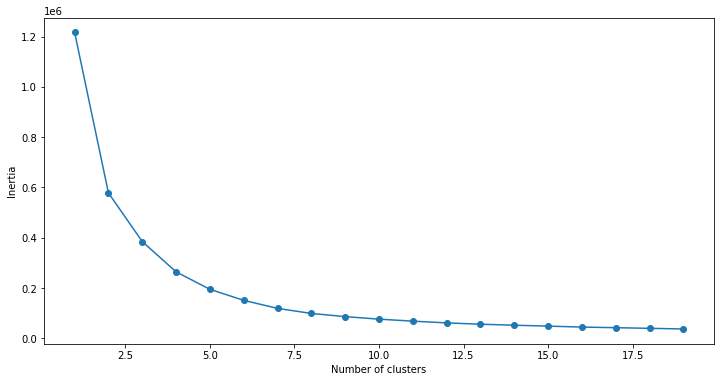

In [54]:
from sklearn.cluster import KMeans

SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [55]:
# seems like SSE decreases the most at group 2
kmeans_clf = KMeans(n_clusters=2)
kmeans_clf.fit(X_train)
print(kmeans_clf.inertia_)

# high inertia suggesting that the dataset is very uniform and the SSE between each points to the centroid are very high

485209.9425447066


In [56]:
from collections import Counter

pred = kmeans_clf.predict(X_test)

In [57]:
Counter(y_test), Counter(pred)

(Counter({0: 949, 1: 634}), Counter({1: 1106, 0: 477}))

In [58]:
# isolate the wrong prediction and check its values
arr = y_test - pred
wrong_idx = np.where([i!=0 for i in arr])[0]

In [59]:
correct_pred = X_test.iloc[~wrong_idx]
correct_pred['TARGET'] = y_test.values[~wrong_idx]
wrong_pred = X_test.iloc[wrong_idx]
wrong_pred['TARGET'] = y_test.values[wrong_idx]

In [60]:
correct_pred.head(50)

,MTBA,MTBF,24 HOUR PRD DURATION,24 HOUR UDT DURATION,TARGET
7912,0.10,6.66,13.326389,7.658056,1
7911,0.11,15.37,15.373611,5.352500,1
7910,0.12,7.40,14.797778,6.411389,1
7909,0.13,7.29,14.581944,6.611667,1
7908,0.16,8.03,16.061389,6.361111,1
7907,0.22,8.63,17.254167,5.481944,1
7898,0.35,19.73,19.725833,2.951667,1
7897,0.37,19.78,19.776389,2.879167,1
7896,0.45,18.94,18.942500,2.605556,1
7895,0.62,20.96,20.964444,1.306944,1


In [61]:
wrong_pred['TARGET'].value_counts()

0    667
1    195
Name: TARGET, dtype: int64

In [62]:
correct_pred['TARGET'].value_counts()

# unsupervised learning clusters both group with 0 as the majority class, not the expected behaviour
# this suggests that the data we train on is too uniform and does not exhibit trend

0    519
1    343
Name: TARGET, dtype: int64

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(data)
pca_2d = pca.transform(data)

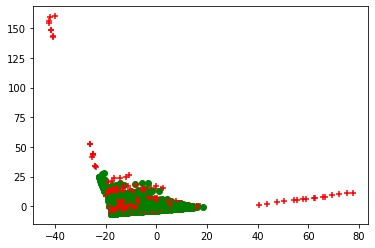

In [64]:
import pylab as pl
for i in range(0, pca_2d.shape[0]):
    if target[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='+')
    elif target[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='o')
    
pl.show()

# not sure how to isolate the outliers

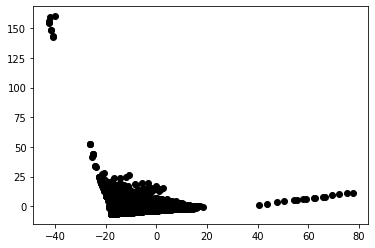

In [65]:
# show PCA plot without group
pl.scatter(pca_2d[:,0],pca_2d[:,1],c='black')
pl.show()

# notice that these plots have outliers, find out what are the outliers

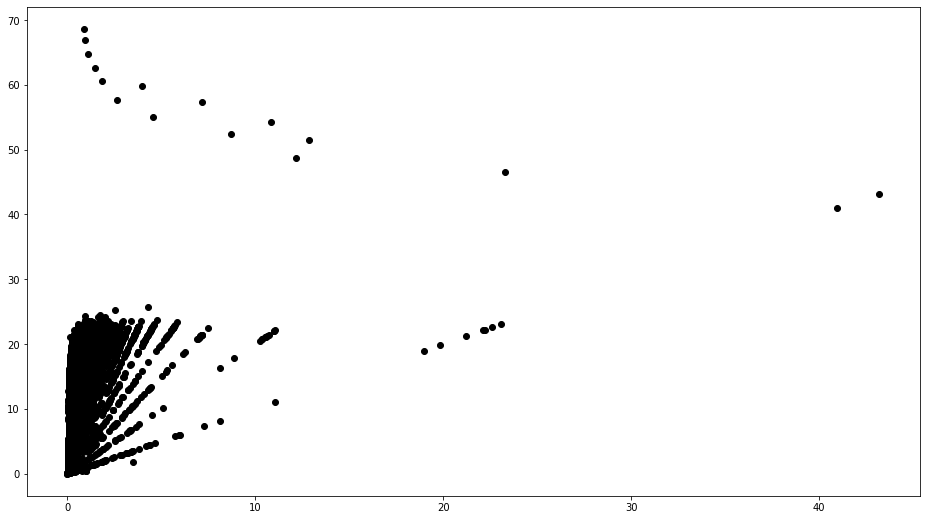

In [66]:
# plot only using MTBA MTBF

plt.figure(figsize=(16,9))
plt.scatter(data['MTBA'], data['MTBF'], c='black')
plt.show()

# 5. Use lagged alarm and state name for unsupervised learning

In [67]:
# maker sure needed data has been loaded
wba127_alarm, wba127_clean_status

(      Equipment  Alarm ID              DT_SET            DT_CLEAR  DELTA_T
 0        WBA127        11 2018-09-17 09:51:54 2018-09-17 09:52:32       38
 1        WBA127        46 2018-09-17 09:52:50 2018-09-17 09:53:00       10
 2        WBA127        23 2018-09-17 09:54:35 2018-09-17 09:55:03       28
 3        WBA127        46 2018-09-17 09:55:48 2018-09-17 09:55:56        8
 4        WBA127        46 2018-09-17 09:58:26 2018-09-17 09:58:45       19
 ...         ...       ...                 ...                 ...      ...
 65409    WBA127        28 2021-08-30 23:54:33 2021-08-30 23:54:34        1
 65410    WBA127        28 2021-08-30 23:54:48 2021-08-30 23:54:49        1
 65411    WBA127        46 2021-08-30 23:55:04 2021-08-30 23:55:07        3
 65412    WBA127        46 2021-08-30 23:56:00 2021-08-30 23:56:24       24
 65413    WBA127        45 2021-08-30 23:57:16 2021-08-30 23:58:08       52
 
 [65414 rows x 5 columns],
          EQ_ID     TIMESTAMP_START       TIMESTAMP_END  DU

In [68]:
# for each alarm event, find the status happening at the time
df = wba127_alarm[['DT_SET', 'Alarm ID']]

state_name = []
for idx, row in df.iterrows():
    timestamp = row['DT_SET']
    filtered_statename = wba127_clean_status[(wba127_clean_status['TIMESTAMP_START']<=timestamp) &
                                            (wba127_clean_status['TIMESTAMP_END']>timestamp)]
    if len(filtered_statename) > 1:
        print(filtered_statename, timestamp)
        raise Exception('There are multiple state name for this timestamp')
    
    if len(filtered_statename)==0:
        state_name.append(None)
    else:
        state_name.append(filtered_statename.iloc[0]['STATE_NAME'])

df['STATE_NAME'] = state_name

In [69]:
lb = LabelEncoder()
df['ENC STATE NAME'] = lb.fit_transform(df['STATE_NAME'])

In [70]:
# lag the alarm and statename
lags = [1,2,3,4,5]
for lag in lags:
    df[f'Alarm ID lagged {lag}'] = df['Alarm ID'].shift(lag)
    df[f'STATE_NAME lagged {lag}'] = df['ENC STATE NAME'].shift(lag)

df = df.dropna().reset_index(drop=True)

In [71]:
# find major down for each alarm event
MAJOR_DOWN = []
for idx, row in df.iterrows():
    start = row['DT_SET']
    end = start+timedelta(hours=6)
    frame = wba127_clean_status[(wba127_clean_status['TIMESTAMP_START']>=start) & \
                                 (wba127_clean_status['TIMESTAMP_START']<=end)]
    UD = frame.loc[frame['LEVEL3']=='UDT']

    if len(UD) == 0: #no record within this 6 hours:
        MAJOR_DOWN.append(0)
    else:
        time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
        if any(time_diff>=3600): #threshold = 3600s
            MAJOR_DOWN.append(1)
        else:
            MAJOR_DOWN.append(0)

df['6 HOUR DOWN'] = MAJOR_DOWN

In [72]:
df

,DT_SET,Alarm ID,STATE_NAME,ENC STATE NAME,Alarm ID lagged 1,STATE_NAME lagged 1,Alarm ID lagged 2,STATE_NAME lagged 2,Alarm ID lagged 3,STATE_NAME lagged 3,Alarm ID lagged 4,STATE_NAME lagged 4,Alarm ID lagged 5,STATE_NAME lagged 5,6 HOUR DOWN
0,2018-12-13 08:14:22,46,SHORT TAIL,38,46.0,50.0,11.0,50.0,46.0,50.0,11.0,50.0,73.0,50.0,0
1,2018-12-13 08:53:35,11,Normal Production,30,46.0,38.0,46.0,50.0,11.0,50.0,46.0,50.0,11.0,50.0,0
2,2018-12-13 08:56:31,10,Waiting For Response,47,11.0,30.0,46.0,38.0,46.0,50.0,11.0,50.0,46.0,50.0,0
3,2018-12-13 08:59:57,28,Waiting For Operator,45,10.0,47.0,11.0,30.0,46.0,38.0,46.0,50.0,11.0,50.0,0
4,2018-12-13 09:04:58,28,Waiting For Operator,45,28.0,45.0,10.0,47.0,11.0,30.0,46.0,38.0,46.0,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60578,2021-08-30 23:54:33,28,Waiting For Operator,45,46.0,38.0,45.0,28.0,45.0,28.0,28.0,45.0,28.0,45.0,1
60579,2021-08-30 23:54:48,28,Waiting For Operator,45,28.0,45.0,46.0,38.0,45.0,28.0,45.0,28.0,28.0,45.0,1
60580,2021-08-30 23:55:04,46,SHORT TAIL,38,28.0,45.0,28.0,45.0,46.0,38.0,45.0,28.0,45.0,28.0,1
60581,2021-08-30 23:56:00,46,SHORT TAIL,38,46.0,38.0,28.0,45.0,28.0,45.0,46.0,38.0,45.0,28.0,1


In [73]:
# Split into training and test set and initialize KMeans to find out the optimal clusters
data = df.drop(['DT_SET', 'STATE_NAME', '6 HOUR DOWN'], axis=1)
target = df['6 HOUR DOWN']

train_idx = int(0.7*len(data))
val_idx = int(0.8*(len(data)))

X_train, y_train = data[:train_idx], target[:train_idx]
X_val, y_val = data[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = data[val_idx:], target[val_idx:]

Text(0, 0.5, 'Inertia')

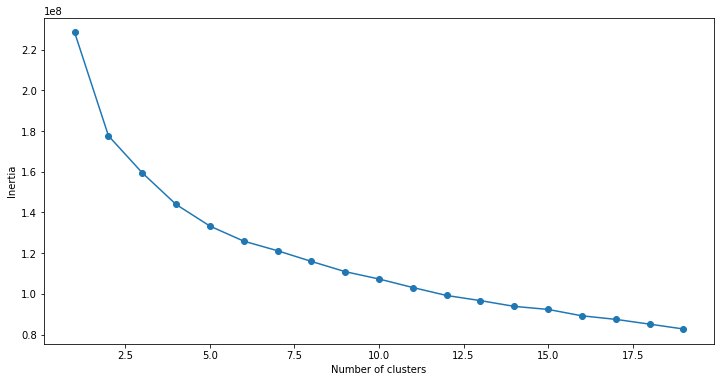

In [74]:
from sklearn.cluster import KMeans

SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(X_train)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# not a very good way to learn since the rate of change in inertia is very minimal compared to previous dataframe

In [75]:
# supervised approach
clf = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    random_state=42,
    class_weight='balanced',
    reg_lambda=0.01
            )

clf.fit(X_train, y_train,
       eval_set=(X_val, y_val),
       eval_metric='auc',
        verbose=False)

pred = clf.predict(X_test)

confusion_matrix(y_test, pred), accuracy_score(y_test, pred)
# also low accuracy

(array([[4441, 4647],
        [1066, 1963]]),
 0.5285136584963275)

# 6. Above method but with newly defined labels

In [80]:
# According to the ratio most of the waiting are minor down, remove all
# 'Waiting For Setup'/'Waiting for Repair' and 'Waiting for Technician' takes up noticable amount of major down
def new_major_down(timeframe_table, wba127_clean_status):
    """
    Clean Status will have all 'Exception' LEVEL3 REMOVED to be able to use the str.contains pandas filter
    Does not affect Major Down count since only EXC is removed
    """
    major_down = []
    for idx, row in timeframe_table.iterrows():
        start = row['DT_SET']
        end = start + timedelta(hours=6)
        
        down_query_filter = ((wba127_clean_status['TIMESTAMP_START']>=start) &
                    (wba127_clean_status['TIMESTAMP_START']<=end) &
                    (~(wba127_clean_status['STATE_NAME'].str.contains('Waiting'))) &
                    (wba127_clean_status['LEVEL3']=='UDT'))
        
        UD = wba127_clean_status[down_query_filter]

        if len(UD) == 0: #no record within this 6 hours:
            major_down.append(0)
        else:
            time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
            if any(time_diff>=3600): #threshold = 3600s
                major_down.append(1)
            else:
                major_down.append(0)
    return np.array(major_down)

In [81]:
# remove LEVEL3 == EXC to find out new major down array
wba127_clean_status = wba127_clean_status[wba127_clean_status['STATE_NAME'].notnull()]

alarm_timeframe = df[['DT_SET']]
new_major_down_arr = new_major_down(alarm_timeframe, wba127_clean_status)

In [82]:
df['NEW 6 HOUR DOWN'] = new_major_down_arr

In [85]:
# Split into training and test set and initialize KMeans to find out the optimal clusters
data = df.drop(['DT_SET', 'STATE_NAME', '6 HOUR DOWN', 'NEW 6 HOUR DOWN'], axis=1)
target = df['NEW 6 HOUR DOWN']

train_idx = int(0.7*len(data))
val_idx = int(0.8*(len(data)))

X_train, y_train = data[:train_idx], target[:train_idx]
X_val, y_val = data[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = data[val_idx:], target[val_idx:]

In [89]:
# supervised approach
clf = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    random_state=42,
    class_weight='balanced',
    learning_rate = 0.1,
    reg_lambda=0.01
            )

clf.fit(X_train, y_train,
       eval_set=(X_val, y_val),
       eval_metric='auc',
        verbose=True)

pred = clf.predict(X_test)

confusion_matrix(y_test, pred), accuracy_score(y_test, pred)
# also low accuracy

[1]	valid_0's auc: 0.639138	valid_0's binary_logloss: 0.685904
[2]	valid_0's auc: 0.650246	valid_0's binary_logloss: 0.678906
[3]	valid_0's auc: 0.66189	valid_0's binary_logloss: 0.672508
[4]	valid_0's auc: 0.676283	valid_0's binary_logloss: 0.668144
[5]	valid_0's auc: 0.67079	valid_0's binary_logloss: 0.666634
[6]	valid_0's auc: 0.667372	valid_0's binary_logloss: 0.661101
[7]	valid_0's auc: 0.682989	valid_0's binary_logloss: 0.654506
[8]	valid_0's auc: 0.682611	valid_0's binary_logloss: 0.652791
[9]	valid_0's auc: 0.680604	valid_0's binary_logloss: 0.650045
[10]	valid_0's auc: 0.677455	valid_0's binary_logloss: 0.647781
[11]	valid_0's auc: 0.680083	valid_0's binary_logloss: 0.643845
[12]	valid_0's auc: 0.678065	valid_0's binary_logloss: 0.642659
[13]	valid_0's auc: 0.6804	valid_0's binary_logloss: 0.639266
[14]	valid_0's auc: 0.682971	valid_0's binary_logloss: 0.637116
[15]	valid_0's auc: 0.686255	valid_0's binary_logloss: 0.633997
[16]	valid_0's auc: 0.682746	valid_0's binary_logloss

(array([[7021, 3803],
        [ 692,  601]]),
 0.6290335891722374)